 <div style="display: flex; background-color: RGB(255,114,0);" >
 <h1 style="margin: auto; padding: 30px; ">ANALYSE DU STOCK ET DES VENTES DU SITE BOTTLENECK</h1>
 </div>

 # OBJECTIF DE CE NOTEBOOK<br>
 Bienvenue dans l'outil plébiscité par les analystes de données Jupyter.<br>
 Il s'agit d'un outil permettant de mixer et d'alterner codes, textes et graphique.<br>
 Cet outil est formidable pour plusieurs raisons:
 + il permet de tester des lignes de codes au fur et à mesure de votre rédaction, de constater immédiatement le résultat d'un instruction, de la corriger si nécessaire.
 + De rédiger du texte pour expliquer l'approche suivie ou les résultats d'une analyse et de le mettre en forme grâce à du code html ou plus simple avec **Markdown**
 + d'agrémenter de graphiques<br>
 Pour vous aider dans vos premiers pas à l'usage de Jupyter et de Python, nous avons rédigé ce notebook en vous indiquant les instructions à suivre.<br>
 Il vous suffit pour cela de saisir le code Python répondant à l'instruction donnée.<br>
 Vous verrez de temps à autre le code Python répondant à une instruction donnée mais cela est fait pour vous aider à comprendre la nature du travail qui vous est demandée.<br>
 Et garder à l'esprit, qu'il n'y a pas de solution unique pour résoudre un problème et qu'il y a autant de résolutions de problèmes que de développeurs ;)... <br>

 <div style="background-color: RGB(51,165,182);" >
 <h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation des librairies et chargement des fichiers</h2>
 </div><br>

 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.1 - Importation des librairies</h3>
 </div>

In [1]:
import pandas as pd # Importation de la librairie Pandas (manipulation de tables)
# Librairies de calcul sur tables :
import math
import numpy as np
# Librairies de création et visualisation graphiques :
import plotly.express as px #Importation de la librairie plotly express
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from IPython.display import display
# Librairies annexes :
import chardet # Librairie d'encodage csv
import warnings; warnings.filterwarnings('ignore') # Librairie de cache warnings

In [2]:
# Amélioration de lecture :
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)
separe = '-'*75

 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.2 - Initialisation du projet</h3>
 </div>

 #### 1.1.2 Automatisation de l'analyse exploratoire et de recherche d'encodage et séparateur d'une feuille de donnée :

In [3]:
#  La fonction d'analyse exploratoire de fichiers prend en entrée quatre arguments :
#  - get_table_info(nom_df, nom_csv)
def get_table_info(df, table_name):
    text = (f"Le tableau {table_name} comporte {df.shape[1]} colonne(s) et {df.shape[0]} observation(s) ou article(s).\n") # Affichage des dimensions de la table
    print(f"Voici les 5 premières lignes du tableau {table_name}:") # Affichage des 5 premières lignes du DataFrame
    display(df.head())
    print(f"Voici les informations du tableau {table_name}:") # Affichage des informations sur le DataFrame
    display(df.info())
    return text

#  - analyse_dataframe(nom_df, nom_csv, optionnellement: nombre_n_colonnes, detail_column_unique)
def analyze_dataframe(df, table_name, columns=None, distinct=None):
# Formatage d'une string avec opérateur ternaire via lambda afin de vérifier et compter les lignes dupliquées et les cellules vides 
    get_info = lambda duplicated_rows, null_cells: (f"il se trouve {duplicated_rows} lignes dupliquées, " if duplicated_rows > 0 else "aucune ligne n'est dupliquée, ") + (f"et il se trouve {null_cells} cellules nulles.\n" if null_cells > 0 else "aucune cellule n'est vide.\n")
    text = f"Dans la table {table_name}, {get_info(sum(df.duplicated()), sum(df.isnull().any()))}"
# L'argument columns effectue une itération sur chaque colonne spécifié si l'argument est appelé
    if columns is not None:
        for column in columns:
            duplicated_values = sum(df.duplicated(column))
            non_null_duplicated_values = sum(df.duplicated(column) & df[column].notnull())
            null_values = df[column].isnull().sum()
# Formatage d'une string avec opérateur ternaire via lambda afin de vérifier et compter les valeurs dupliquées et/ou nulles. 
            text += f"Dans la colonne {column}, "
            text += f"il se trouve {duplicated_values} valeurs dupliquées, dont {non_null_duplicated_values} valeurs non-nulles " if duplicated_values > 0 else  f"il ne se trouve pas de valeur dupliquée. Le nombre d'articles correspond au nombre de lignes.\n"
            text += f"et {null_values} valeurs nulles.\nIl s'y trouve donc {df[column].nunique()} valeurs distinctes sur {df.shape[0]} lignes.\n" if null_values > 0 and duplicated_values > 0 else ""

    if distinct is not None:
        unique_values = df[distinct].unique()
        unique_values_str = list(map(str, unique_values))
        unique_values_text = ', '.join(unique_values_str)
        text += f"Dans la colonne {distinct}, il se trouve {df[distinct].nunique()} valeurs distinctes, que sont : {unique_values_text}.\n"
    
    print(text)

# Détection de l'encodage et du séparateur du fichier csv :
def detect_encoding_and_separator(filename):
# Via la déclaration "with", le fichier est parcouru en mode binaire afin de détecter l'encodage : 
    with open(filename, 'rb') as f:
        result = chardet.detect(f.read())
    encode = result['encoding']
    print(f"Le fichier est encodé en {encode}.")
# De nouveau avec "with", cette fois-ci le fichier est parcouru en mode text, afin d'examiner la structure même de la première ligne :
    with open(filename, 'r', encoding=encode) as f:
        separator = ';' if ';' in f.readline() else (',' if ',' in f.readline() else '\t')
        print(f"Le fichier sépare les colonnes par le '{separator}'.") if separator else print("Le séparateur n'a pas pu être détecté.")
        return encode, separator

 #### 1.1.3 Chargement des fichiers

In [4]:
# Chargement des feuilles de données
web = pd.read_excel("../feuilles_de_données/web.xlsx") # Importation du fichier web.xlsx
stock = pd.read_excel("../feuilles_de_données/erp.xlsx") # Importation du fichier erp.xlsx
link = pd.read_excel("../feuilles_de_données/liaison.xlsx") # importation du fichier liaison.xlsx
# Renommage de la table link :
link_sku = link.rename(columns={'id_web': 'sku'})
# importation du fichier caracteristiques_vins.csv :
csv_file = "../feuilles_de_données/caracteristiques_vins.csv"
encode, separator = detect_encoding_and_separator(csv_file)
caracs = pd.read_csv(csv_file, sep=separator, encoding=encode)

Le fichier est encodé en Windows-1252.
Le fichier sépare les colonnes par le ';'.


 <div style="background-color: RGB(51,165,182);" >
 <h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 2 - Analyse exploratoire des fichiers</h2>
 </div><br>
 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1 - Analyse exploratoire du fichier erp.xlsx</h3>
 </div>
 Nous ne connaissons pas les différentes données des quatre tables. Nous allons donc commencer l'analyse par la découverte des colonnes, les types, le nombre de lignes.
 Il faut aussi vérifier les lignes et valeurs non nulles, ou dupliquées.

In [5]:
# Afficher les infos d'ERP :
get_table_info(stock, 'ERP')
#Afficher les valeurs distinctes de la colonne stock_status
analyze_dataframe(stock, 'ERP', ['product_id'], 'stock_status')

Voici les 5 premières lignes du tableau ERP:


,product_id,onsale_web,price,stock_quantity,stock_status
0,3847,1,24.2,0,outofstock
1,3849,1,34.3,0,outofstock
2,3850,1,20.8,0,outofstock
3,4032,1,14.1,0,outofstock
4,4039,1,46.0,0,outofstock


Voici les informations du tableau ERP:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      825 non-null    int64  
 1   onsale_web      825 non-null    int64  
 2   price           825 non-null    float64
 3   stock_quantity  825 non-null    int64  
 4   stock_status    825 non-null    object 
dtypes: float64(1), int64(3), object(1)
memory usage: 32.4+ KB


None

Dans la table ERP, aucune ligne n'est dupliquée, aucune cellule n'est vide.
Dans la colonne product_id, il ne se trouve pas de valeur dupliquée. Le nombre d'articles correspond au nombre de lignes.
Dans la colonne stock_status, il se trouve 2 valeurs distinctes, que sont : outofstock, instock.



In [6]:
#À quelle(s) autre(s) colonne(s) sont-elles liées ?
stock['stock_status_num'] = stock.stock_status.map({'instock': 1, 'outofstock': 0})
print(f"Voici la correlation entre les différentes colonnes :\n{stock.corr()}")

Voici la correlation entre les différentes colonnes :
                  product_id  onsale_web     price  stock_quantity  \
product_id          1.000000   -0.372854  0.112821       -0.108501   
onsale_web         -0.372854    1.000000  0.030876        0.119618   
price               0.112821    0.030876  1.000000       -0.275648   
stock_quantity     -0.108501    0.119618 -0.275648        1.000000   
stock_status_num    0.089389    0.167545 -0.034393        0.312773   

                  stock_status_num  
product_id                0.089389  
onsale_web                0.167545  
price                    -0.034393  
stock_quantity            0.312773  
stock_status_num          1.000000  


  La correlation la plus proche de 1 est celle entre stock_quantity et stock_status_num, qui est stock_status converti en booléen.

In [7]:
#Création d'une colonne "stock_status_2
#La valeur de cette deuxième colonne sera fonction de la valeur dans la colonne "stock_quantity"
#si la valeur de la colonne "stock_quantity" est nulle renseigner "outofstock" sinon mettre "instock"
stock['stock_status_2'] = stock.stock_quantity.apply(lambda x: 'instock' if x > 0 else 'outofstock')
stock = stock[["product_id", "onsale_web", "price", "stock_quantity", "stock_status", "stock_status_2", "stock_status_num"]]

In [8]:
#Vérifions que les 2 colonnes sont identiques:
#Les 2 colonnes sont strictement identiques si les valeurs de chaque ligne sont strictement identiques 2 à 2
#La comparaison de 2 colonnes peut se réaliser simplement avec l'instruction ci-dessous:
print(f"La conformité entre les deux colonnes est {stock.stock_status.equals(stock.stock_status_2)}")

#Le résultat est l'affichage de True ou False pour chacune des lignes du dataset
#C'est un bon début, mais difficile à exploiter

La conformité entre les deux colonnes est False


In [9]:
#Mais il est possible de synthétiser ce résultat en effectuant la somme de cette colonne:
#True vaut 1 et False 0
#Nous devrions obtenir la somme de 824 qui correspond au nombre de lignes dans ce dataset
print(f"la somme des valeurs conforme entre les deux colonnes s'élève à {sum(stock.stock_status == stock.stock_status_2)}, sur les {stock.stock_status_2.count()} lignes présentes. ")

la somme des valeurs conforme entre les deux colonnes s'élève à 824, sur les 825 lignes présentes. 


In [10]:
#Si les colonnes ne sont absolument pas identiques ligne à ligne alors identifier la ligne en écart
##Dans ce cas je vous ce lien pour apprendre à réaliser des filtres dans Pandas:
##https://bitbucket.org/hrojas/learn-pandas/src/master/
##Lesson 3
display(stock.query('stock_status != stock_status_2').loc[:, ['stock_status', 'stock_status_2']])

,stock_status,stock_status_2
443,instock,outofstock


In [11]:
#Corriger la ou les données incohérentes
stock.loc[443, 'stock_status'] = 'outofstock' if stock.loc[443, 'stock_quantity'] == 0 else 'instock'
print(f"La conformité entre les deux colonnes est {stock.stock_status.equals(stock.stock_status_2)}")

La conformité entre les deux colonnes est True


 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1.1 - Analyse exploratoire de chaque variable du fichier erp.xlsx</h3>
 </div><br>

 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1.1.1 - Analyse de la variable PRIX</h3>
 </div>


In [12]:
#Vérification des prix: Y a t-il des prix non renseignés, négatif ou nul?
filter_stock = stock.price.where(stock.price <= 0, np.nan).notnull()
#Afficher le ou les prix non renseignés dans la colonne "price"
print(f"Nombres d'article avec un prix non renseignés: {filter_stock.sum()} article.")
# Afficher le prix minimum de la colonne "price"
print(f"Le prix le plus faible proposé est : {stock['price'].min()}€.")
# Afficher le prix maximum de la colonne "price"
print(f"Le prix le plus élevé proposé est : {stock['price'].max()}€.")

Nombres d'article avec un prix non renseignés: 0 article.
Le prix le plus faible proposé est : 5.2€.
Le prix le plus élevé proposé est : 225.0€.


 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1.1.2 - Analyse de la variable STOCK</h3>
 </div>


In [13]:
# Afficher la quantité minimum de la colonne "stock_quantity"
print(f"La quantité minimum de stock parmi les différents produits se dénombre à {stock['stock_quantity'].min()} articles.")
# Afficher la quantité maximum de la colonne "stock_quantity"
print(f"La quantité maximum de stock parmi les différents produit se dénombre à {stock['stock_quantity'].max()} articles.")

La quantité minimum de stock parmi les différents produits se dénombre à 0 articles.
La quantité maximum de stock parmi les différents produit se dénombre à 578 articles.


 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.1.1.3 - Analyse de la variable ONSALE_WEB</h3>
 </div>

 Vérification de la colonne onsale_web et des valeurs qu'elle contient? Que signifient-elles?

In [14]:
display(stock[['onsale_web','product_id']].groupby(['onsale_web']).count())

,product_id
onsale_web,
0,108
1,717


  La colonne **[onsale_web]** représentée par un booléen (0 ou 1), signifie la présence ou non du produit sur le site web.
 > Cela nous est utile afin de ne garder que les produit du stock présents sur le site, et par conséquent, de se délester de cette colonne.<br>

In [15]:
print(f"Les produits figurants sur le site web se dénombrent à {stock.onsale_web.sum()}, parmi les {stock.onsale_web.count()} articles enregistrés.\n{len(stock) - stock.onsale_web.sum()} articles ne sont donc pas mis en ventes\n")

Les produits figurants sur le site web se dénombrent à 717, parmi les 825 articles enregistrés.
108 articles ne sont donc pas mis en ventes



 Quelles sont les colonnes à conserver selon vous?

In [16]:
stock_onsaleTrue=stock[stock.onsale_web == 1]

  - Uniquement les colonnes :
  >    - ["product_id"] ;
  >    - ["price"] ;
  >    - ["stock_quantity"].

In [17]:
#Supprimer les colonnes comportant le libellé "stock_status"
#Cette colonne est redondante avec la colonne "stock_quantity". Dans notre projet cette information n'est pas utile.
stock_lighter = stock_onsaleTrue.drop(['stock_status', 'stock_status_2', 'onsale_web', 'stock_status_num'], axis=1)
stock_lighter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 717 entries, 0 to 824
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      717 non-null    int64  
 1   price           717 non-null    float64
 2   stock_quantity  717 non-null    int64  
dtypes: float64(1), int64(2)
memory usage: 22.4 KB


 #### Résumé d'_ERP :_
  - 3 colonnes et 717 lignes dont l'index n'est pas réinitialisé (allant de 0 à 824);
  - Une clé "primaire" **[product_id]**, est un **int64**. Aucune donnée de ses n'est dupliquée, ni nulle ;
  - Aucune des données d'_**ERP**_ ne semble transgresser le type de donnée attribuée à la colonne.
  - l’intérêt est d'analyser les données selon les ventes sur le site internet. Dans la colonne onsale_web, 108 produits ne semblent pas figurer dans le catalogue. Donc nous les écartons, puis la colonne avec.
  - La colonne **[stock_status]**, semble redondante avec **[stock_quantity]**. Nous pourrons l'abandonner.
 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.2 - Analyse exploratoire du fichier web.xlsx</h3>
 </div>


In [18]:
# Afficher les infos de Web :
get_table_info(web, 'Web')
analyze_dataframe(web, 'Web', ['sku'])

Voici les 5 premières lignes du tableau Web:


,sku,virtual,downloadable,rating_count,average_rating,total_sales,tax_status,tax_class,post_author,post_date,post_date_gmt,post_content,post_title,post_excerpt,post_status,comment_status,ping_status,post_password,post_name,post_modified,post_modified_gmt,post_content_filtered,post_parent,guid,menu_order,post_type,post_mime_type,comment_count
0,bon-cadeau-25-euros,0,0,0,0.0,10.0,taxable,NaN,1.0,2018-06-01 13:53:46,2018-06-01 11:53:46,NaN,Bon cadeau de 25€,"<span style=""color: #a85253;""><strong>Parlons ...",publish,closed,closed,NaN,bon-cadeau-de-25-euros,2018-06-01 14:13:57,2018-06-01 12:13:57,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
1,15298,0,0,0,0.0,6.0,taxable,NaN,2.0,2018-02-08 12:58:52,2018-02-08 11:58:52,NaN,Pierre Jean Villa Saint-Joseph Préface 2018,"Il exhale un nez subtil, racé avec du poivre f...",publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-preface-2018,2019-12-30 09:30:29,2019-12-30 08:30:29,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
2,15296,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 13:49:41,2018-02-08 12:49:41,NaN,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,Les vieilles vignes lui apportent une rare pro...,publish,closed,closed,NaN,pierre-jean-villa-saint-joseph-tilde-2017,2019-12-21 09:00:17,2019-12-21 08:00:17,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
3,15300,0,0,0,0.0,0.0,taxable,NaN,2.0,2018-02-08 14:08:36,2018-02-08 13:08:36,NaN,Pierre Jean Villa Crozes-Hermitage Accroche Co...,"Dentelle de fruit de jeunes syrah, aux tanins ...",publish,closed,closed,NaN,pierre-jean-villa-croze-hermitage-accroche-coe...,2020-06-26 18:15:03,2020-06-26 16:15:03,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0
4,19814,0,0,0,0.0,3.0,taxable,NaN,2.0,2018-02-09 14:01:05,2018-02-09 13:01:05,NaN,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,Gamine représente tout le fruité et la gourman...,publish,closed,closed,NaN,pierre-jean-villa-igp-gamine-2018,2020-01-04 16:36:01,2020-01-04 15:36:01,NaN,0.0,https://www.bottle-neck.fr/?post_type=product&...,0.0,product,NaN,0.0


Voici les informations du tableau Web:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   sku                    1428 non-null   object        
 1   virtual                1513 non-null   int64         
 2   downloadable           1513 non-null   int64         
 3   rating_count           1513 non-null   int64         
 4   average_rating         1430 non-null   float64       
 5   total_sales            1430 non-null   float64       
 6   tax_status             716 non-null    object        
 7   tax_class              0 non-null      float64       
 8   post_author            1430 non-null   float64       
 9   post_date              1430 non-null   datetime64[ns]
 10  post_date_gmt          1430 non-null   datetime64[ns]
 11  post_content           0 non-null      float64       
 12  post_title             

None

Dans la table Web, il se trouve 82 lignes dupliquées, et il se trouve 25 cellules nulles.
Dans la colonne sku, il se trouve 798 valeurs dupliquées, dont 714 valeurs non-nulles et 85 valeurs nulles.
Il s'y trouve donc 714 valeurs distinctes sur 1513 lignes.



  Selon vous, quelles sont les colonnes à conserver ?
  > ["post_title", "total_sales","post_date_gmt"] de manière définitive, et ["post_name", "sku", "post_status", "post_type", "post_mime_type"] de manière temporaire<br>

 Si vous avez défini des colonnes à supprimer, effectuer l'opération

In [19]:
web_lighterCol = web.drop(['virtual', 'downloadable', 'rating_count', 'average_rating', 'tax_status', 'tax_class', 'post_author', 'post_date', 'post_content', 'post_excerpt', 'comment_status', 'ping_status', 'post_password', 'post_modified', 'post_modified_gmt', 'post_content_filtered', 'post_parent', 'guid', 'menu_order', 'comment_count'], axis = 1)
print(web_lighterCol.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1513 entries, 0 to 1512
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   sku             1428 non-null   object        
 1   total_sales     1430 non-null   float64       
 2   post_date_gmt   1430 non-null   datetime64[ns]
 3   post_title      1430 non-null   object        
 4   post_status     1430 non-null   object        
 5   post_name       1430 non-null   object        
 6   post_type       1430 non-null   object        
 7   post_mime_type  714 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 94.7+ KB
None


 #### Visualisation des valeurs de la colonne sku
Quelles sont les valeurs qui ne semblent pas respecter la règle de codification?
display(web_lighter.sku.unique())

In [20]:
web_lighter_wrong_sku = web_lighterCol['sku'].apply(lambda x: not str(x).isdigit())
wrong_sku = web_lighterCol.loc[web_lighter_wrong_sku, 'sku'].unique()
print(f"Les codes ne respectant pas la règle de codification sont {wrong_sku}.")

Les codes ne respectant pas la règle de codification sont ['bon-cadeau-25-euros' nan '13127-1'].


Pour les codes articles identifiés, réalisé une analyse et définissez l'action à entreprendre
 Créer un sous-ensemble avec les lignes invalides

In [21]:
invalid_rows = web_lighterCol.loc[web_lighter_wrong_sku]
# Marquer les lignes dupliquées
invalid_rows['duplicated'] = invalid_rows.duplicated(keep=False)
# Remplacer les valeurs NaN par une valeur spécifique
invalid_rows = invalid_rows.fillna('missing')
# Compter le nombre de lignes dupliquées pour chaque groupe
invalid_rows['count_even_row'] = invalid_rows.groupby(invalid_rows.columns.tolist())['duplicated'].transform('sum')
# Supprimer les lignes dupliquées
invalid_rows = invalid_rows.drop_duplicates()
# Afficher les résultats
display(invalid_rows.sort_values(by='sku'))

,sku,total_sales,post_date_gmt,post_title,post_status,post_name,post_type,post_mime_type,duplicated,count_even_row
797,13127-1,0.0,2020-06-09 13:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,publish,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,product,missing,False,0
1511,13127-1,0.0,2020-06-09 13:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,publish,clos-du-mont-olivet-chateauneuf-du-pape-2007-2,attachment,image/jpeg,False,0
0,bon-cadeau-25-euros,10.0,2018-06-01 11:53:46,Bon cadeau de 25€,publish,bon-cadeau-de-25-euros,product,missing,False,0
1209,bon-cadeau-25-euros,10.0,2018-06-01 11:53:46,Bon cadeau de 25€,publish,bon-cadeau-de-25-euros,attachment,image/jpeg,False,0
178,missing,missing,missing,missing,missing,missing,missing,missing,True,83
470,missing,0.0,2018-07-31 10:07:23,Pierre Jean Villa Côte Rôtie Fongeant 2017,publish,pierre-jean-villa-cote-rotie-fongeant-2017,product,missing,False,0
471,missing,0.0,2018-08-08 09:23:43,Pierre Jean Villa Condrieu Jardin Suspendu 2018,publish,pierre-jean-villa-condrieu-suspendu-2018,product,missing,False,0


  La clé pour chaque ligne est-elle uniques? ou autrement dit, y a-t-il des doublons?
  > La plupart des doublons sont des valeurs nulles, mais 2 doublons sont discernables, celles des 2 codes sku non réglementaires, avec un point commun :
  > - La valeur product et la valeur attachment de la colonne 'post_mime_type', cette dernière valeur accompagnée d'une image jpeg.
  Nous pouvons donc assumer que la duplication de toutes les valeurs de 'sku' non nulles, proviennent des pièces jointes jpeg.
  Par contre, dans les autres colonnes, il se trouve 2 valeurs de plus non nulles, il faudrait donc les inspecter.
  Identifier les lignes sans code articles

In [22]:
web_sku_nul = web_lighterCol['sku'].isnull()
print(f"Il se trouve {sum(web_sku_nul)} codes article nulle") 

Il se trouve 85 codes article nulle


  Les lignes sans code article semble être toutes non renseignés
     Pour s'en assurer réaliser les étapes suivantes:
 1 - Créer un dataframe avec uniquement les lignes sans code article

In [23]:
web_no_sku = web_lighterCol[web_sku_nul]
# 2 - utiliser la fonction stock_web.info() sur ce nouveau dataframe pour observer le nombre de valeur renseignée dans chacune des colonnes
web_no_sku.info()
# 3 - Que constatez-vous?
web_filter_notna = (web_no_sku.drop('sku', axis=1).notna().any(axis=1))
web_notna = web_no_sku[web_filter_notna]
display(web_notna)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 178 to 796
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   sku             0 non-null      object        
 1   total_sales     2 non-null      float64       
 2   post_date_gmt   2 non-null      datetime64[ns]
 3   post_title      2 non-null      object        
 4   post_status     2 non-null      object        
 5   post_name       2 non-null      object        
 6   post_type       2 non-null      object        
 7   post_mime_type  0 non-null      object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 6.0+ KB


,sku,total_sales,post_date_gmt,post_title,post_status,post_name,post_type,post_mime_type
470,NaN,0.0,2018-07-31 10:07:23,Pierre Jean Villa Côte Rôtie Fongeant 2017,publish,pierre-jean-villa-cote-rotie-fongeant-2017,product,NaN
471,NaN,0.0,2018-08-08 09:23:43,Pierre Jean Villa Condrieu Jardin Suspendu 2018,publish,pierre-jean-villa-condrieu-suspendu-2018,product,NaN


 Dans chaque colonnes se trouve 2 valeurs, hormis pour sku et post_mime_type.<br>
 Nous avons donc aucune utilité à garder ces lignes dans la table actuelle.<br>
 Par contre, un nom permet d'identifier l'article, et donc de pouvoir réfléchir à le réintroduire ou non.

In [24]:
web_lighter_na = web_lighterCol.dropna(subset=['sku'])
print(f"Il se trouve {sum(web_lighter_na['sku'].isnull())} codes article nulle") 

Il se trouve 0 codes article nulle


 Nous pouvons maintenant vérifier une dernière fois les infos du tableau afin d'entreprendre les actions finales de la table Web

In [25]:
web_lighter_na.info()
print(f'''Le résultat de la somme de lignes dans sku, soit {sum(web_lighter_na.sku.value_counts())}, soustrait par la somme de lignes dans post_mime_type, soit {sum(web_lighter_na.post_mime_type.value_counts())}, 
est égale à {(web_result := sum(web_lighter_na.sku.value_counts())-sum(web_lighter_na.post_mime_type.value_counts()))}''')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428 entries, 0 to 1512
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   sku             1428 non-null   object        
 1   total_sales     1428 non-null   float64       
 2   post_date_gmt   1428 non-null   datetime64[ns]
 3   post_title      1428 non-null   object        
 4   post_status     1428 non-null   object        
 5   post_name       1428 non-null   object        
 6   post_type       1428 non-null   object        
 7   post_mime_type  714 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 100.4+ KB
Le résultat de la somme de lignes dans sku, soit 1428, soustrait par la somme de lignes dans post_mime_type, soit 714, 
est égale à 714


 Nous pouvons donc clore le nettoyage de la table web, par la suppression des lignes contenant la valeur 'attachment', puis retirer les colonnes superflues de la table

In [26]:
web_lighter_clean = web_lighter_na.drop(web_lighter_na[web_lighter_na['post_type'] == 'attachment'].index)
analyze_dataframe(web_lighter_clean, 'Web', ['sku'])

web_lighter_clean[web_lighter_clean.sku.duplicated()].info()
web_lighter_clean.sort_values(by=['sku', 'post_type'])

web_almost_light = web_lighter_clean.drop(['post_type', 'post_mime_type', 'post_status'], axis = 1)
web_almost_light.info()

Dans la table Web, aucune ligne n'est dupliquée, et il se trouve 1 cellules nulles.
Dans la colonne sku, il ne se trouve pas de valeur dupliquée. Le nombre d'articles correspond au nombre de lignes.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   sku             0 non-null      object        
 1   total_sales     0 non-null      float64       
 2   post_date_gmt   0 non-null      datetime64[ns]
 3   post_title      0 non-null      object        
 4   post_status     0 non-null      object        
 5   post_name       0 non-null      object        
 6   post_type       0 non-null      object        
 7   post_mime_type  0 non-null      object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 0.0+ bytes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 798
Data columns (total 5 columns):
 #   Colum

  ### Résumé de _Web :_
  - 5 colonnes et 716 lignes dont l'index n'est pas réinitialisé (allant de 0 à 798) ;
  - Une clé "primaire" **[sku]** est un **object** ;
  - Parmi les 28 colonnes, 4 colonnes ne contiennent aucune données, **[tax_class]**, **[post_content]**, **[post_password]**, **[post_content_filtered]**. Ces colonnes sont donc impertinentes.
  - De plus, l'objectif étant l'analyse du chiffre d'affaire, seule la colonne indiquant le nombre de ventes, **[total_sales]**, serait pertinente.
         Par contre, il faut pouvoir identifier chacun des articles, donc garder les colonnes de code article, **[sku]**, et du titre du produit, **[post_title]**, serait pertinent.
         Ce n'est pas demandé, mais peut-être que la date selon le GMT, **[post_date_gmt]**, ne serait pas impertinent si il fallait comparer le nombre total de ventes, selon la date de publication.
 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.3 - Analyse exploratoire du fichier liaison.xlsx</h3>
 </div>

In [27]:
#Dimension du dataset
#Nombre d'observations
#Nombre de caractéristiques
#Consulter le nombre de colonnes
#La nature des données dans chacune des colonnes
#Le nombre de valeurs présentes dans chacune des colonnes
#Les valeurs de la colonne "product_id" sont elles toutes uniques?
#Les valeurs de la colonne "id_web" sont-elles toutes uniques?
analyze_dataframe(link_sku, "Liaison", ['product_id', 'sku'])

Dans la table Liaison, aucune ligne n'est dupliquée, et il se trouve 1 cellules nulles.
Dans la colonne product_id, il ne se trouve pas de valeur dupliquée. Le nombre d'articles correspond au nombre de lignes.
Dans la colonne sku, il se trouve 90 valeurs dupliquées, dont 0 valeurs non-nulles et 91 valeurs nulles.
Il s'y trouve donc 734 valeurs distinctes sur 825 lignes.



In [28]:
#Avons-nous des articles sans correspondances?
sum_na = link_sku['sku'].isna().sum()
print(f"Il se trouve {sum_na} articles sans correspondance.")

Il se trouve 91 articles sans correspondance.


 ### Résumé de _Link :_
  - 2 colonnes et 825 lignes ;
  - Une clé "primaire" **[product_id]** est un **int64** ;
  - Aucune donnée de **[product_id]** n'est dupliquée, ni nulle ;
  - Aucune des données de _**LINK**_ ne semble transgresser le type de donnée.
  - Sa seconde colonne se nomme **[id_web]**, mais doit se renommer **[sku]**, c'est donc une feuille qui comme son nom l'indique permet de lier _**WEB**_, et _**ERP**_ ensemble.

 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">2.4 - Analyse exploratoire du fichier caracteristiques_vins.xlsx</h3>
 </div>

In [29]:
# Affichage des infos de Caractéristiques_vins :
get_table_info(caracs, "Caractéristiques_Vins")
analyze_dataframe(caracs, "Caractéristiques_Vins", ['post_name'])

Voici les 5 premières lignes du tableau Caractéristiques_Vins:


,post_name,poids,Région,Domaine,Appellation,Couleur,Cépage,Millésime,Garde,Contenance,Degré d'alcool,Température dégustation,Alliance mets
0,pierre-jean-villa-saint-joseph-preface-2018,1.5 kg,Rhône,Pierre Jean Villa,Saint Joseph,Rouge,100% Syrah,2020.0,4-7 ans,75cl,13%,15°C,"Charcuterie, Lapin, Viande rouge, Volaille"
1,pierre-jean-villa-saint-joseph-tilde-2017,1.5 kg,Rhône,Pierre Jean Villa,Saint Joseph,Rouge,100% Syrah,2019.0,6-8 ans,75cl,13%,15°C,"Charcuterie, Viande rouge, Volaille"
2,pierre-jean-villa-croze-hermitage-accroche-coe...,1.5 kg,Rhône,Pierre Jean Villa,Crozes-Hermitage,Rouge,100% Syrah,2020.0,3-5 ans,75cl,13%,15°C,"Viande rouge, Volaille"
3,pierre-jean-villa-igp-gamine-2018,1.5 kg,Rhône,Pierre Jean Villa,Collines Rhodaniennes,Rouge,100% Syrah,2020.0,3-5 ans,75cl,13%,14°C,"Charcuterie, Viande rouge, Volaille"
4,pierre-jean-villa-cote-rotie-carmina-2017,1.5 kg,Rhône,Pierre Jean Villa,Côte Rôtie,Rouge,100% Syrah,2019.0,10-20 ans,75cl,13%,17°C,"Gibier, Viande rouge"


Voici les informations du tableau Caractéristiques_Vins:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   post_name                611 non-null    object 
 1   poids                    611 non-null    object 
 2   Région                   586 non-null    object 
 3   Domaine                  577 non-null    object 
 4   Appellation              559 non-null    object 
 5   Couleur                  566 non-null    object 
 6   Cépage                   571 non-null    object 
 7   Millésime                541 non-null    float64
 8   Garde                    569 non-null    object 
 9   Contenance               611 non-null    object 
 10  Degré d'alcool           586 non-null    object 
 11  Température dégustation  574 non-null    object 
 12  Alliance mets            574 non-null    object 
dtypes: float64(1), object(1

None

Dans la table Caractéristiques_Vins, aucune ligne n'est dupliquée, et il se trouve 10 cellules nulles.
Dans la colonne post_name, il ne se trouve pas de valeur dupliquée. Le nombre d'articles correspond au nombre de lignes.



In [30]:
#Quels sont les produits avec des informations manquantes?
caracs_nul = caracs.isnull().any(axis=1)
caracs_nan = caracs[caracs_nul]
display(caracs_nan)
print(caracs_nan.to_string(max_colwidth=39))

,post_name,poids,Région,Domaine,Appellation,Couleur,Cépage,Millésime,Garde,Contenance,Degré d'alcool,Température dégustation,Alliance mets
60,gosset-champagne-grande-reserve,1.5 kg,Champagne,Gosset,Champagne,Blanc,"10% Pinot Meunier, 45% Chardonnay, 45% Pinot Noir",NaN,4 ans,75cl,12%,10°C,"Apéritif, Fruits cuits, Sucré-salé, Tajine"
62,champagne-gosset-grand-rose,1.5 kg,Champagne,Gosset,Champagne,NaN,"50% Chardonnay, 50% Pinot Noir",NaN,4 ans,75cl,12%,10°C,"Apéritif, Desserts, Foie gras, Poissons"
63,champagne-mailly-gc-brut-reserve,1.5 kg,Champagne,Mailly Grand Cru,Champagne,Blanc,"25% Chardonnay, 75% Pinot Noir",NaN,4 ans,75cl,12%,10°C,"Apéritif, Chaource, Légumes croquants, Suprême..."
64,champagne-mailly-grand-cru-extra-brut-2012,1.5 kg,Champagne,Mailly Grand Cru,Champagne,Blanc,"25% Chardonnay, 75% Pinot Noir",NaN,4 ans,75cl,12%,10°C,"Apéritif, Carpaccios, Caviar, Huîtres"
65,champagne-mailly-grand-cru-brut-rose,1.5 kg,Champagne,Mailly Grand Cru,Champagne,NaN,"10% Chardonnay, 90% Pinot Noir",NaN,4 ans,75cl,12%,10°C,"Apéritif, Tapas, Viande Blanche"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,saumaize-michelin-pouilly-fuisse-ampelopsis-2016,1.5 kg,Bourgogne,Saumaize-Michelin,Pouilly-Fuissé,Blanc,Chardonnay,2018.0,NaN,75cl,13%,12°C,"Apéritif, Fromages, Poissons, Volaille"
581,la-preceptorie-cotes-du-roussillon-coume-marie...,1.5 kg,Languedoc-Roussillon,La Preceptorie,NaN,Blanc,"Carignan Blanc, Grenache Blanc, Grenache Gris,...",2020.0,6-8 ans,75cl,15%,12°C,"Poisson en sauce, Viande Blanche, Volaille"
582,la-preceptorie-cotes-du-roussillon-blanc-terre...,1.5 kg,Languedoc-Roussillon,La Preceptorie,NaN,Blanc,"Grenache Gris, Macabeu",2020.0,6-8 ans,75cl,15%,12°C,"Crustacés, Fruits de mer, Poisson grillé"
601,emile-boeckel-cremant-chardonnay-extra-brut-2016,1.5 kg,Alsace,Emile Boeckel,Crémant d'Alsace,Blanc,Chardonnay,NaN,3-5 ans,75cl,12%,9°C,"Apéritif, Fromages, Huîtres, Poissons"


                                  post_name   poids                Région                                 Domaine                      Appellation Couleur                                  Cépage  Millésime        Garde Contenance Degré d'alcool Température dégustation                           Alliance mets
60          gosset-champagne-grande-reserve  1.5 kg             Champagne                                  Gosset                        Champagne   Blanc  10% Pinot Meunier, 45% Chardonnay, ...        NaN        4 ans       75cl            12%                    10°C  Apéritif, Fruits cuits, Sucré-salé,...
62              champagne-gosset-grand-rose  1.5 kg             Champagne                                  Gosset                        Champagne     NaN          50% Chardonnay, 50% Pinot Noir        NaN        4 ans       75cl            12%                    10°C  Apéritif, Desserts, Foie gras, Pois...
63         champagne-mailly-gc-brut-reserve  1.5 kg             Champagne

  Est-il possible de corriger les données manquantes?
  > A la main oui, en recherchant sur internet par nom de produit, car aucune donnée de produit n'est manquante.
  Par contre, les colonnes contenant des valeurs manquantes, ne sont pas utiles au projet, et pourraient être supprimées.

In [31]:
caracs_lighter = caracs.drop(["poids", "Région", "Domaine", "Appellation", "Couleur", "Cépage", "Millésime", "Garde", "Contenance", "Degré d'alcool", "Température dégustation", "Alliance mets"], axis=1)
caracs_lighter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 611 entries, 0 to 610
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   post_name  611 non-null    object
dtypes: object(1)
memory usage: 4.9+ KB


 ### Résumé de _Caractéristiques_Vins :_
  - 13 colonnes et 611 lignes ;
  - Une clé "primaire" **[post_name]** est un **object** ;
  - Aucune donnée de **[post_name]** n'est dupliquée, ni nulle ;
  - Aucune des données de _**CARACS**_ ne semble transgresser le type de donnée.
  - La colonne **[post_name]**, comporte le même nom qu'une des colonnes de la table WEB, et comporte, avec plus de lisibilité, les mêmes données que la colonne **[post_title]**.
  - Sur la même base que dans le paragraphe de _**WEB**_, seule la colonne post_name est pertinente. Il ne serait pas utile de lier ces deux tables intrinsèquement.
        Cependant elle réfère l'une partie du catalogue, cette information pourrait se révéler utile aussi.

 <div style="background-color: RGB(51,165,182);" >
 <h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 3 - Jonction des fichiers</h2>
 </div>

  #### 3.0.5 - Transversalité des feuilles :

In [32]:
stock_link_occur = (stock.columns).intersection(link_sku.columns)
print(f"Colonne occurrente des tables ERP et Liaison : {stock_link_occur}")
print(separe)
## La table link et web :
web_link_occur = (web.columns).intersection(link_sku.columns)
print(f"Colonne occurrente des tables Web et Liaison : {web_link_occur}")
print(separe)
## La table web et caracs :
web_caracs_occur = (web.columns).intersection(caracs.columns)
print(f"Colonne occurrente des tables Web et Caractéristiques_vins : {web_caracs_occur}")

Colonne occurrente des tables ERP et Liaison : Index(['product_id'], dtype='object')
---------------------------------------------------------------------------
Colonne occurrente des tables Web et Liaison : Index(['sku'], dtype='object')
---------------------------------------------------------------------------
Colonne occurrente des tables Web et Caractéristiques_vins : Index(['post_name'], dtype='object')


  - Les feuilles ne possédant pas de colonnes communes :
    - Les feuilles _**ERP**_ et _**Web**_ ne possèdent aucune colonne communes. _**Liaison**_ permettra de faire le pont entre ces deux feuilles.
        - Liaison comporte la clé étrangère de _**ERP**_, **[product_id]**, et de _**Web**_, **[id_web]** devenant **[sku]**.
    - La feuille _**Caractéristiques_vins**_ n'a en commun aucune colonne avec les feuilles _**Liaison**_ et _**ERP**_.
        - _**Web**_ fera office de pont, comportant la clé étrangère **[post_name]**, en plus d'être liée à ERP grâce à la table _**Liaison**_.

 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 3.1 - Jonction du fichier stock et df_liaison</h3>
 </div>

 Fusion des fichiers stock_web_erp et stock_web_liaison

In [33]:
stock_link_Full = pd.merge(stock_lighter, link_sku, on='product_id', how='outer', indicator=True)

In [34]:
# Y a t-il des lignes ne "matchant" entre les 2 fichiers?
analyze_dataframe(stock_link_Full, 'ERP_Liaison',['product_id'])
stock_link_Full._merge.value_counts()

stock_link_Full.drop(stock_link_Full[stock_link_Full['_merge'] == 'right_only'].index, inplace=True)
stock_link_Full.drop("_merge", axis=1, inplace = True)
stock_link_Full.info()

Dans la table ERP_Liaison, aucune ligne n'est dupliquée, et il se trouve 3 cellules nulles.
Dans la colonne product_id, il ne se trouve pas de valeur dupliquée. Le nombre d'articles correspond au nombre de lignes.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 717 entries, 0 to 716
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_id      717 non-null    int64  
 1   price           717 non-null    float64
 2   stock_quantity  717 non-null    float64
 3   sku             714 non-null    object 
dtypes: float64(2), int64(1), object(1)
memory usage: 28.0+ KB


 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 3.2 - Jonction du fichier df_merge et df_web</h3>
 </div>

Fusionnez les datasets df_merge et df_web

In [35]:
middle_join = pd.merge(stock_link_Full, web_almost_light, on='sku',  how = 'outer', indicator=True)

In [36]:
#Avons-nous des lignes sans correspondances?
analyze_dataframe(middle_join, 'ERP_Liaison_Web', ['product_id'])
join_na = middle_join['sku'].isna().sum()
print(f"Il se trouve {join_na} articles sans correspondance.")
mask = middle_join['sku'].isna()
result = middle_join.loc[mask]
display(result)

Dans la table ERP_Liaison_Web, aucune ligne n'est dupliquée, et il se trouve 5 cellules nulles.
Dans la colonne product_id, il ne se trouve pas de valeur dupliquée. Le nombre d'articles correspond au nombre de lignes.

Il se trouve 3 articles sans correspondance.


,product_id,price,stock_quantity,sku,total_sales,post_date_gmt,post_title,post_name,_merge
228,4594,144.0,0.0,NaN,NaN,NaT,NaN,NaN,left_only
229,5070,84.7,0.0,NaN,NaN,NaT,NaN,NaN,left_only
230,5075,43.3,0.0,NaN,NaN,NaT,NaN,NaN,left_only


  N'ayant même pas de code article, il ne sont dont pas vendable, le nombre total de ventes est nul, il n'est donc pas utile de les intégrer dans l'analyse du chiffre d'affaire.

In [37]:
drop_null = middle_join[middle_join['sku'].isna()].index
middle_join_clean = middle_join.drop(drop_null)
data_middle = middle_join_clean.drop('_merge', axis=1)
print(data_middle.info())
display(data_middle)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 716
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   product_id      714 non-null    int64         
 1   price           714 non-null    float64       
 2   stock_quantity  714 non-null    float64       
 3   sku             714 non-null    object        
 4   total_sales     714 non-null    float64       
 5   post_date_gmt   714 non-null    datetime64[ns]
 6   post_title      714 non-null    object        
 7   post_name       714 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(3)
memory usage: 50.2+ KB
None


,product_id,price,stock_quantity,sku,total_sales,post_date_gmt,post_title,post_name
0,3847,24.2,0.0,15298,6.0,2018-02-08 11:58:52,Pierre Jean Villa Saint-Joseph Préface 2018,pierre-jean-villa-saint-joseph-preface-2018
1,3849,34.3,0.0,15296,0.0,2018-02-08 12:49:41,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,pierre-jean-villa-saint-joseph-tilde-2017
2,3850,20.8,0.0,15300,0.0,2018-02-08 13:08:36,Pierre Jean Villa Crozes-Hermitage Accroche Co...,pierre-jean-villa-croze-hermitage-accroche-coe...
3,4032,14.1,0.0,19814,3.0,2018-02-09 13:01:05,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,pierre-jean-villa-igp-gamine-2018
4,4039,46.0,0.0,19815,0.0,2018-02-12 08:04:37,Pierre Jean Villa Côte Rôtie Carmina 2017,pierre-jean-villa-cote-rotie-carmina-2017
...,...,...,...,...,...,...,...,...
712,6930,8.4,83.0,16135,5.0,2020-04-25 11:22:38,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,mouthes-le-bihan-aime-chai-2015
713,7023,27.5,15.0,15891,0.0,2020-05-02 12:53:40,Camin Larredya Jurançon Sec La Virada 2018,camin-larredya-jurancon-sec-la-virada-2018
714,7025,69.0,2.0,15887,0.0,2020-05-02 13:00:54,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,jamet-cote-rotie-fructus-voluptas-2018
715,7247,54.8,23.0,13127-1,0.0,2020-06-09 13:42:04,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,clos-du-mont-olivet-chateauneuf-du-pape-2007-2


 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 3.3 - Jonction du fichier df_merge et df_caracteristiques</h3>
 </div>

In [38]:
#Fusion de la table df_merge et df_caracteristiques 
data_full = pd.merge(data_middle, caracs_lighter, on='post_name',  how = 'outer')
analyze_dataframe(data_full, 'ERP_Liaison_Web_Caractéristiques')

Dans la table ERP_Liaison_Web_Caractéristiques, aucune ligne n'est dupliquée, aucune cellule n'est vide.



In [39]:
data_merge = data_full.drop(['post_name', 'product_id', 'sku', 'post_date_gmt'], axis = 1)
df = data_merge[['post_title', 'stock_quantity', 'price', 'total_sales']]

 <div style="background-color: RGB(51,165,182);" >
 <h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 4 - Analyse univarié des prix</h2>
 </div>

 Nous allons tirer des graphiques contenant des valeurs de colonnes telles que :

 - Le revenu par articles, soit l'**[income_items]** :
   - Produit du prix unitaire **[price]** par l'écoulement des stocks **[total_sales]** ;
 - Le nombre d'écart-type, soit le Z-score du prix **[zscore_per_price]** :
   - Quotient de la division du résultat, de la soustraction entre le prix unitaire **[price]** par la moyenne des prix unitaire **[price]**, par l'écart-type du prix unitaire **[price]** ;

 Afin d'obtenir les résultats les plus cohérents et servant de prévisions, il faudra mettre en évidence les valeurs aberrantes (outliers), grâce à :

 - l'écart-type ;
 - l'interquartile ;
 - le zscore ;
 #### Préparation des nouvelles colonnes, de leurs appels et d'équations :

In [40]:
price = df.price
total_sales = df.total_sales
# Utilisation de la fonction describe de Pandas pour l'etude des mesures de dispersions
outlier = price.describe()
# Initialisation des outliers
# Premier quartile
q1 = outlier['25%']
# Troisième quartile
q3 = outlier['75%']
# Écart interquartile
iqr = q3 - q1
# Calcul des valeurs aberrantes
outlier_threshold = 1.5 * iqr
# Création des limites, respectivement supérieur, et inférieur
limit_higher = q3 + outlier_threshold
limit_lower = q1 - outlier_threshold
# Stockage des valeurs aberrantes 
outliers = price[(price < limit_lower) | (price > limit_higher)]
# Totalise le décompte des valeurs aberrantes
sum_outliers = len(outliers)
# Calcul de la proportion des valeurs aberrantes
prop_outliers = sum_outliers / len(price)
# Calculer la moyenne du prix
mean = sum(price) / len(price)
mean_higher = price > mean
# Calculer l'écart-type du prix
std = math.sqrt(sum((price - mean)**2) / len(price))

# Calculer le prix médian
def median(column):
    n = len(column)
    sort_col = sorted(column)
    if n % 2 == 0:
        # Cas pair
        mid = n // 2
        return (sort_col[mid - 1] + sort_col[mid]) / 2
    else:
        # Cas impair
        mid = (n - 1) // 2
        return sort_col[mid]

mediane = median(price)
# Création des colonnes
    # Créez une colonne calculant le CA par article
df["income_items"] = price*total_sales
income_items = df.income_items
# Calcul du chiffre d'affaire
turnover = sum(income_items)

df["zscore_price"] = (price - mean) / std
zscore = df.zscore_price

print(df.info())

df[['post_title', 'price', 'total_sales', 'income_items', 'stock_quantity', 'zscore_price']]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 713
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   post_title      714 non-null    object 
 1   stock_quantity  714 non-null    float64
 2   price           714 non-null    float64
 3   total_sales     714 non-null    float64
 4   income_items    714 non-null    float64
 5   zscore_price    714 non-null    float64
dtypes: float64(5), object(1)
memory usage: 39.0+ KB
None


,post_title,price,total_sales,income_items,stock_quantity,zscore_price
0,Pierre Jean Villa Saint-Joseph Préface 2018,24.2,6.0,145.2,0.0,-0.298410
1,Pierre Jean Villa Saint-Joseph Rouge Tildé 2017,34.3,0.0,0.0,0.0,0.065016
2,Pierre Jean Villa Crozes-Hermitage Accroche Co...,20.8,0.0,0.0,0.0,-0.420752
3,Pierre Jean Villa IGP Collines Rhodaniennes Ga...,14.1,3.0,42.3,0.0,-0.661837
4,Pierre Jean Villa Côte Rôtie Carmina 2017,46.0,0.0,0.0,0.0,0.486015
...,...,...,...,...,...,...
709,Mouthes Le Bihan Côtes de Duras L'Aimé Chai 2015,8.4,5.0,42.0,83.0,-0.866939
710,Camin Larredya Jurançon Sec La Virada 2018,27.5,0.0,0.0,15.0,-0.179667
711,Domaine Jamet Côte Rôtie Fructus Voluptas 2018,69.0,0.0,0.0,2.0,1.313620
712,Clos du Mont-Olivet Châteauneuf-du-Pape 2007,54.8,0.0,0.0,23.0,0.802664


 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 4.1 - Exploration par la visualisation de données</h3>
 </div>


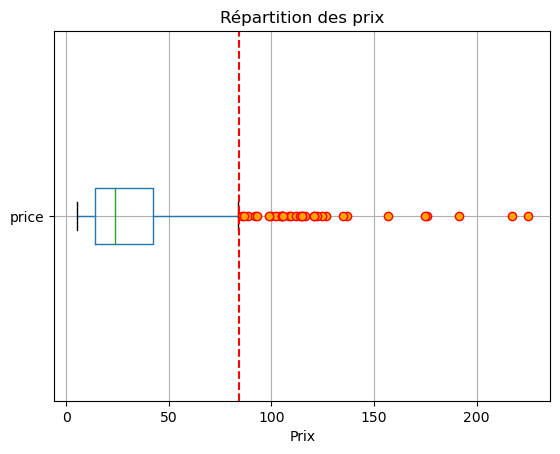

In [41]:
# Création d'une Boite à moustache de la répartition des prix grâce à Pandas
import matplotlib.pyplot as plt

ax = df.boxplot(column='price',
                vert=False,
                flierprops=dict(markerfacecolor='orange',
                                markeredgecolor='red'))
ax.set(title='Répartition des prix', xlabel='Prix')
ax.axvline(x=round(limit_higher,2), color='red', linestyle='--')
plt.show()

 Le boxplot est représenté par le carré et ses "moustaches", indiquant à leur extrémité, les seuils de valeurs aberrantes.<br>
 Les "moustaches" représentent les valeurs dites "cohérentes, rationnelles", tandis que les points oranges représentent les valeurs aberrantes.<br>
 La ligne pointillée rouge indique visiblement le seuil de ces dernières.<br>
 La ligne verte représente la médiane des prix. Le coté gauche et droit du carré sont respectivement le quantile 1 et 3.<br>
 Ce qui se trouve à gauche du quantile 1 représente les 25% d'articles aux prix les plus bas, et à droite du quantile 3 sont représentés les 25% d'articles aux prix les plus hauts.<br>
 Les boxplot et points rouges illustrent le prix, indiqué par l'axe X, de chaque produits

In [42]:
# Autre méthode avec plotly express
fig = go.Figure()
fig.add_trace(go.Violin(x=df['price'], box_visible=True, points='outliers', name='Price', orientation='h',
                         marker=dict(color='orange'),
                         line=dict(color='red')))
fig.update_layout(title='Répartition des prix', xaxis_title='Prix', yaxis_title='Volume d\'articles')
fig.show()

 J'ai choisi le violin plot pour visualiser les données autrement, sans dénaturer la pertinence des infos.<br>
 Cela représente le mélange d'un boxplot, comme vu précédemment, d'un violin plot, et d'un marker des outliers.<br>
 Ce graphique lie donc :
 - Répartition des prix ;
 - densité des valeurs ;

  ## Etape 4.2 - Exploration par l'utilisation de méthodes statistique
  ### Etape 4.2.1 - Identification par le Z-index
  #### Outliers

In [43]:
# Affichage du nombre de références
print(f"Il s'y cumule {round(outlier[0],1)} articles")
# Affichage de la moyenne
print(f"Le prix moyen d'une bouteille est de {round(outlier[1],1)}€")
# Affichage l'écart-type
print(f"l'écart type est de {round(outlier[2],1)}€")
# Affichage la médiane
print(f"La médiane est de {round(outlier[5],1)}€")
# Définissez un seuil pour les articles "outliers" en prix
print(f"Les valeurs aberrantes se situent en dehors de {round(limit_lower, 2)}€ et {round(limit_higher,2)}€")
# Définissez le nombre d'articles et la proportion de l'ensemble du catalogue "outliers"
print(f'''Il y a {sum_outliers} références produit dans la dataset qui sont considérées comme des valeurs aberrantes.
La proportion de valeurs aberrantes dans l'ensemble du catalogue est de {prop_outliers:.2%}.''')


# Compter le nombre d'outliers supérieurs à la limite supérieure
# Afficher les résultats
print(f"Nombre d'outliers supérieurs à la limite supérieure: {sum_outliers}")
print(f"Proportion d'outliers supérieurs à la limite supérieure: {prop_outliers:.2%}")

Il s'y cumule 714.0 articles
Le prix moyen d'une bouteille est de 32.5€
l'écart type est de 27.8€
La médiane est de 23.6€
Les valeurs aberrantes se situent en dehors de -28.01€ et 84.29€
Il y a 32 références produit dans la dataset qui sont considérées comme des valeurs aberrantes.
La proportion de valeurs aberrantes dans l'ensemble du catalogue est de 4.48%.
Nombre d'outliers supérieurs à la limite supérieure: 32
Proportion d'outliers supérieurs à la limite supérieure: 4.48%


 Selon vous, ces outliers sont-ils justifiés ? Comment le démontrer si cela est possible ?<br>
 > Pour déterminer s'il est justifié d'inclure les outliers dans notre analyse, une approche consiste à évaluer si ces valeurs extrêmes sont cohérentes avec la nature de nos données.<br>
 Plusieurs méthodes peuvent être utilisées pour cela, telles que l'analyse de la distribution des données, l'examen de la provenance des outliers ou encore l'étude des valeurs adjacentes aux outliers.<br>
 Dans le cas spécifique de notre étude sur les prix des bouteilles de vin, il convient de noter que la limite inférieure ne peut être inférieure au prix minimum d'une bouteille, puisqu'un prix de vente est toujours positif et supérieur à 0.<br>

 Toutefois, si l'outlier inférieur est inférieur, proche ou égal à 0€, il est possible qu'il soit justifié dans la mesure où cela pourrait correspondre à une promotion ou à une erreur de saisie.<br>
 D'un autre côté, si l'outlier supérieur semble incohérent, il peut être utile de comparer les prix avec ceux proposés par la concurrence pour le vin le plus cher de Bottleneck.<br>
 En fin de compte, la décision d'inclure ou d'exclure les outliers de notre analyse dépendra du contexte de notre étude et de l'objectif de notre analyse.<br>

 Si le outlier supérieur semble incohérent, nous pourrions analyser chez la concurrence le prix donné au vin le plus cher de Bottleneck :

In [44]:
pd.set_option('display.max_colwidth', 47)
print(f"Voici le vin le plus onéreux de Bottleneck :\n {df[df['price'] == price.max()].to_string(index=False)}")
pd.set_option('display.max_colwidth', None)

Voici le vin le plus onéreux de Bottleneck :
                                     post_title  stock_quantity  price  total_sales  income_items  zscore_price
Champagne Egly-Ouriet Grand Cru Millésimé 2008             0.0  225.0          5.0        1125.0      6.926939


 Nous pouvons trouver le moins cher au prix de 299,95€, mais 2 sites le proposent à 350-400€, et 2 autres entre 828 et 961,28€.

 Quel est le seuil prix dont z-score est supérieur à 3?

In [45]:
display(df[zscore > 3].sort_values(by='zscore_price', ascending=False))
print(f"Il se trouve {sum(zscore > 3)} articles possédant un zscore supérieur à 3.")
# Et pour un seuil supérieur à 2
print(f"Il se trouve {sum(zscore > 2)} articles possédant un zscore supérieur à 2.")

,post_title,stock_quantity,price,total_sales,income_items,zscore_price
199,Champagne Egly-Ouriet Grand Cru Millésimé 2008,0.0,225.0,5.0,1125.0,6.926939
426,David Duband Charmes-Chambertin Grand Cru 2014,20.0,217.5,0.0,0.0,6.657068
587,Coteaux Champenois Egly-Ouriet Ambonnay Rouge 2016,10.0,191.3,3.0,573.9,5.714318
218,Cognac Frapin VIP XO,8.0,176.0,13.0,2288.0,5.163781
553,Camille Giroud Clos de Vougeot 2016,12.0,175.0,0.0,0.0,5.127798
221,Cognac Frapin Château de Fontpinot 1989 20 Ans d'Age,3.0,157.0,0.0,0.0,4.480108
381,Domaine Des Croix Corton Charlemagne Grand Cru 2016,13.0,137.0,5.0,685.0,3.760451
642,Champagne Gosset Célébris Vintage 2007,10.0,135.0,2.0,270.0,3.688486
201,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,2.0,126.5,11.0,1391.5,3.382632
511,Domaine Weinbach Gewurztraminer Grand Cru Furstentum SGN 2010 1/2,12.0,124.8,0.0,0.0,3.321461


Il se trouve 14 articles possédant un zscore supérieur à 3.
Il se trouve 30 articles possédant un zscore supérieur à 2.


 ## Etape 5 - Analyse univariée du CA et des quantités vendues
 ### Etape 5.1 - Analyse des ventes en CA
 #### Etape 5.1.1 Calculer le CA du site web
 Calculez la somme de la colonne "ca_par_article"

In [46]:
print(f"Le chiffre d'affaire effectué sur le site est de {turnover}€")

Le chiffre d'affaire effectué sur le site est de 70568.6€


 Ce résultat correspond au chiffre d'affaire du site web

 #### Etape 5.1.2 - Palmarès des articles en CA

In [47]:
# Effectuer le tri dans l'ordre décroissant du CA du dataset stock_web_merge
sorted_income_items = df.sort_values(by='income_items', ascending=False)
# Réinitialiser l'index du dataset par un reset_index
sorted_income_items = sorted_income_items.reset_index(drop=True)
# Afficher les 20 premier articles en CA
display(sorted_income_items.head(20))

,post_title,stock_quantity,price,total_sales,income_items,zscore_price
0,Champagne Gosset Grand Blanc de Blancs,0.0,49.0,96.0,4704.0,0.593963
1,Champagne Gosset Grand Rosé,11.0,49.0,87.0,4263.0,0.593963
2,Cognac Frapin VIP XO,8.0,176.0,13.0,2288.0,5.163781
3,Champagne Gosset Grand Millésime 2006,8.0,53.0,30.0,1590.0,0.737895
4,Champagne Gosset Grande Réserve,1.0,39.0,40.0,1560.0,0.234135
5,Champagne Egly-Ouriet Grand Cru Blanc de Noirs,2.0,126.5,11.0,1391.5,3.382632
6,Champagne Egly-Ouriet Grand Cru Millésimé 2008,0.0,225.0,5.0,1125.0,6.926939
7,Elian Daros Côtes du Marmandais Clos Baquey 2015,0.0,29.0,36.0,1044.0,-0.125693
8,Domaine Giudicelli Patrimonio Blanc 2019,120.0,25.2,41.0,1033.2,-0.262428
9,Gilles Robin Crozes-Hermitage Rouge Papillon 2019,157.0,16.6,62.0,1029.2,-0.571880


 Graphique en barre des 20 premiers articles en quantité de vente, avec plotly express :

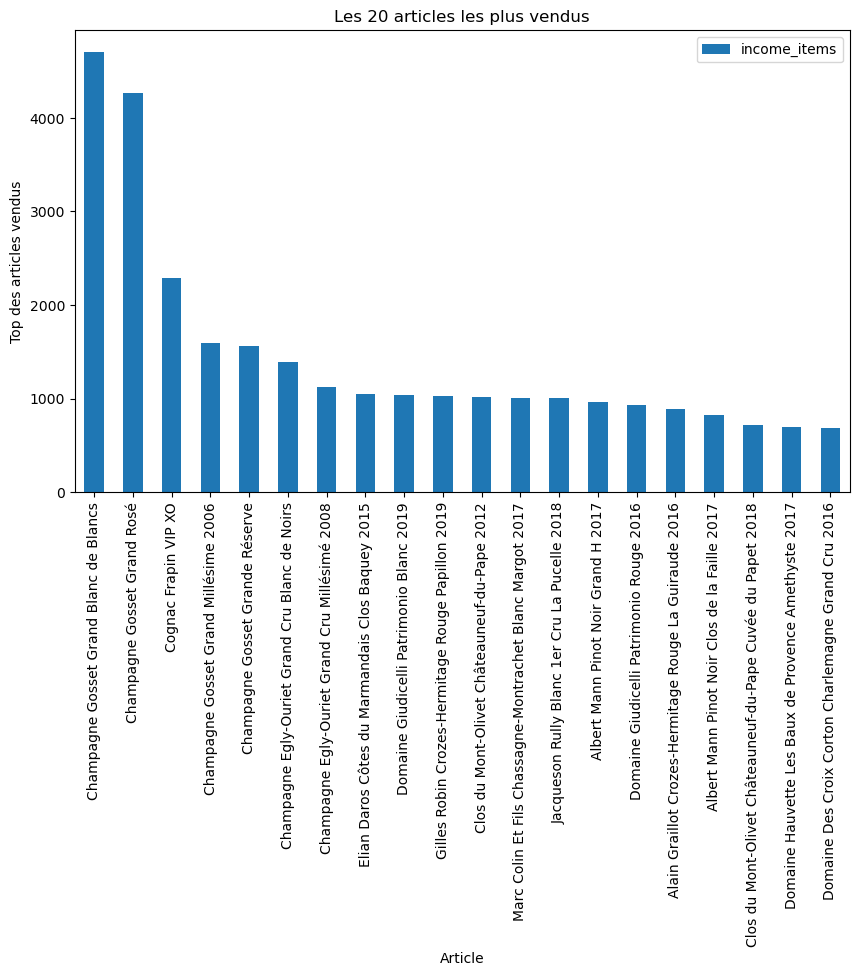

In [48]:
df_graph_top = sorted_income_items
df_graph_top20 = df_graph_top.head(20)
graph = df_graph_top20.plot(kind="bar", x="post_title", y="income_items",figsize=(10,6))
graph.set(xlabel="Article", ylabel="Top des articles vendus")
graph.set_title('Les 20 articles les plus vendus')
plt.show()

 Nous pouvons constater dans ce graphique deux articles se distinguant par un revenu bien supérieur aux autres vins.<br>
 Le premier article en terme de vente est 2 fois supérieur au troisième article le plus vendu.
 #### Etape 5.1.3 - Calculer le 20 / 80 en CA
 Créer une colonne calculant la part du CA de la ligne dans le dataset

In [49]:
df_seller = df.copy()
df_seller['turnover_part'] = income_items / turnover * 100
df_sort_seller = df_seller.sort_values(by='turnover_part', ascending=False)
df_sort_seller = df_sort_seller.reset_index(drop=True)
# Créer une colonne réalisant la somme cumulative de la colonne précédemment créée
df_sort_seller['turnover_cumul'] = df_sort_seller['turnover_part'].cumsum()
# Grâce au deux colonnes créées précédemment, calculer le nombre d'articles représentant 80% du CA
seller_80pct = df_sort_seller[df_sort_seller['turnover_cumul'] >= 80].index[0]
sum_80pct = seller_80pct + 1
print(f"Le nombre d'articles représentant 80% du CA est de {sum_80pct} articles")
# Afficher la proportion que représentent ce groupe d'articles dans le catalogue entier du site web
total_articles = len(df_sort_seller)
proportion_80pct = sum_80pct / total_articles
print(f"La proportion d'articles représentant plus de 80% du CA est de {proportion_80pct:.2%}")
print(df_sort_seller.to_string())

Le nombre d'articles représentant 80% du CA est de 131 articles
La proportion d'articles représentant plus de 80% du CA est de 18.35%
                                                                             post_title  stock_quantity   price  total_sales  income_items  zscore_price  turnover_part  turnover_cumul
0                                                Champagne Gosset Grand Blanc de Blancs             0.0   49.00         96.0        4704.0      0.593963       6.665854        6.665854
1                                                           Champagne Gosset Grand Rosé            11.0   49.00         87.0        4263.0      0.593963       6.040930       12.706785
2                                                                  Cognac Frapin VIP XO             8.0  176.00         13.0        2288.0      5.163781       3.242235       15.949020
3                                                 Champagne Gosset Grand Millésime 2006             8.0   53.00         30.0      

 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 5.2 - Analyse des ventes en Quantités</h3>
 </div>

 #### Palmares des articles en quantité

 Effectuer le tri dans l'ordre décroissant de quantités vendues du dataset stock_web_merge

,post_title,stock_quantity,price,total_sales,income_items,zscore_price
0,Domaine Montrose Côtes de Thongue Rosé 2019,578.0,7.6,16.0,121.6,-0.895725
1,Domaine Giudicelli Patrimonio Rouge 2016,363.0,25.2,37.0,932.4,-0.262428
2,Château Turcaud Bordeaux Rouge 2016,289.0,7.0,2.0,14.0,-0.917315
3,Philippe Nusswitz Duché d'Uzès Orénia Rouge 2017,284.0,8.5,29.0,246.5,-0.863341
4,Domaine de l'Hortus Pic Saint-Loup La Bergerie Rouge 2018,276.0,13.5,9.0,121.5,-0.683427
5,Mourgues du Grès Costières de Nîmes Galets Rouges 2019,267.0,8.7,11.0,95.7,-0.856144
6,Château Turcaud Bordeaux Rosé 2019,257.0,6.5,1.0,6.5,-0.935306
7,François Bergeret Hautes Côtes de Beaune Rouge 2017,237.0,11.8,0.0,0.0,-0.744597
8,Maurel Pays d'Oc Syrah 2019,211.0,5.8,8.0,46.4,-0.960494
9,Château de La Liquière Faugères Les Amandiers Rouge 2019,209.0,9.3,12.0,111.6,-0.834554


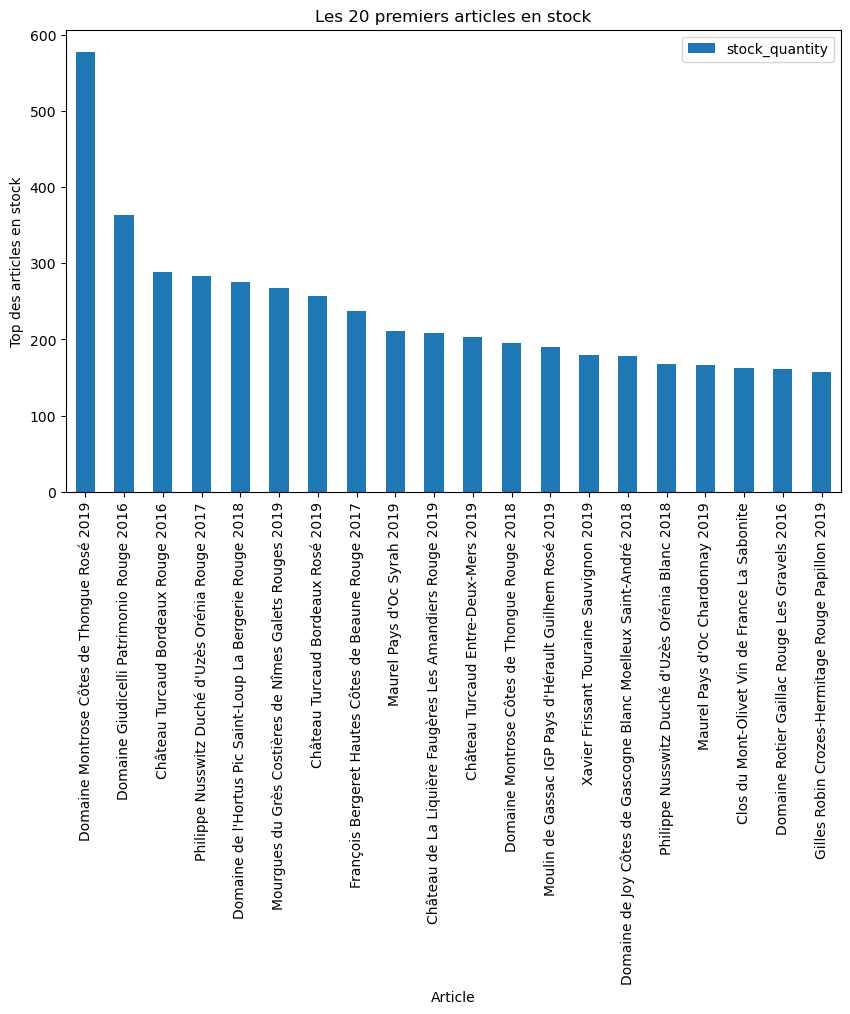

In [50]:
sorted_qtt_items = df.sort_values(by='stock_quantity', ascending=False)
# Réinitialiser l'index du dataset par un reset_index
sorted_qtt_items
sorted_qtt_items = sorted_qtt_items.reset_index(drop=True)
# Afficher les 20 premier articles en quantité
display(sorted_qtt_items.head(20))
# Graphique en barre des 20 premiers articles avec plotly express
df_graph_top = sorted_qtt_items
df_graph_top20 = df_graph_top.head(20)
graph = df_graph_top20.plot(
    kind="bar", x="post_title", y="stock_quantity", figsize=(10, 6))
graph.set(xlabel="Article", ylabel="Top des articles en stock")
graph.set_title('Les 20 premiers articles en stock')
plt.show()

 #### Calculer le 20 / 80 en CA

 Créer une colonne calculant la part en quantité de la ligne dans le dataset

In [51]:
sumtotal_sales = df['total_sales'].sum()

def calculate_sales_part(row):
    return row['total_sales'] / sumtotal_sales * 100

df['sales_part'] = df.apply(calculate_sales_part, axis=1)
df_sort_qtt = df.sort_values(by='sales_part', ascending=False)
df_sort_qtt = df_sort_qtt.reset_index(drop=True)
# Créer une colonne réalisant la somme cumulative de la colonne précédemment créée
df_sort_qtt['sales_cumul'] = df_sort_qtt.sales_part.cumsum()
# Grâce au deux colonnes créées précédemment, calculer le nombre d'articles représentant 80% des ventes en quantité
qtt_items80 = df_sort_qtt[df_sort_qtt.sales_cumul >= 80].index[0]
sum_qtt80 = qtt_items80 + 1
print(f"Le nombre d'articles représentant 80% des ventes en quantité est de {sum_qtt80} articles")
# Calculer la proportion que représente ce groupe d'articles dans le catalogue entier du site web
proportion_qtt80 = sum_qtt80 / total_articles
# Afficher la proportion
print(f"Le groupe d'articles représentant 80% des ventes en quantité représente {proportion_qtt80:.2%} du catalogue entier du site web.")

print(df_sort_qtt.to_string())

Le nombre d'articles représentant 80% des ventes en quantité est de 151 articles
Le groupe d'articles représentant 80% des ventes en quantité représente 21.15% du catalogue entier du site web.
                                                                             post_title  stock_quantity   price  total_sales  income_items  zscore_price  sales_part  sales_cumul
0                                                Champagne Gosset Grand Blanc de Blancs             0.0   49.00         96.0        4704.0      0.593963    3.350785     3.350785
1                                                           Champagne Gosset Grand Rosé            11.0   49.00         87.0        4263.0      0.593963    3.036649     6.387435
2                                     Gilles Robin Crozes-Hermitage Rouge Papillon 2019           157.0   16.60         62.0        1029.2     -0.571880    2.164049     8.551483
3                                 Moulin de Gassac IGP Pays d'Hérault Guilhem Rosé 2019        

 ## Conclusion :
 Nous pouvons donc constater 2 résultats à partir de la proportion des articles représentant 80% des ventes en quantité, et le groupe d'articles représentant 80% du chiffre d'affaire :
 - Respectivement 18.35% et 21.15%.
 Ce qui serait bien de vérifier ? Quels sont les articles en communs parmi ces deux groupes

In [52]:
seller_100pct = df_sort_seller[df_sort_seller.turnover_cumul == 100].index[0]
qtt_items100 = df_sort_qtt[df_sort_qtt.sales_cumul >= 100].index[0]

df1 = df_sort_seller.iloc[:seller_100pct]
df2 = df_sort_qtt.iloc[:qtt_items100]
df_100pct = pd.merge(df1, df2, on='post_title', how='outer', indicator=True)

# Supprimer les lignes où les colonnes 'turnover_cumul' et 'sales_cumul' sont égales à 0
df_100pct = df_100pct[(df_100pct['turnover_cumul'] != 0) & (df_100pct['sales_cumul'] != 0)]

# Réinitialiser l'index du dataframe
df_100pct = df_100pct.reset_index(drop=True)
df_100pct = df_100pct.rename(columns={'total_sales_x': 'total_sales', 'stock_quantity_x': 'stock_quantity', 'price_x': 'price', 'income_items_x': 'income_items', 'zscore_price_x': 'zscore_price'})

# Regrouper les données par la colonne 'turnover_cumul' et trier les groupes par ordre croissant
grouped = df_100pct.groupby('turnover_cumul').apply(lambda x: x.sort_values('turnover_cumul'))

df_100pct_clean = df_100pct[['post_title', 'stock_quantity', 'price', 'total_sales', 'income_items', 'zscore_price', 'turnover_part', 'turnover_cumul', 'sales_part', 'sales_cumul', '_merge']]
# Afficher les résultats
print(df_100pct_clean.to_string())

                                                                      post_title  stock_quantity   price  total_sales  income_items  zscore_price  turnover_part  turnover_cumul  sales_part  sales_cumul      _merge
0                                         Champagne Gosset Grand Blanc de Blancs             0.0   49.00         96.0        4704.0      0.593963       6.665854        6.665854    3.350785     3.350785        both
1                                                    Champagne Gosset Grand Rosé            11.0   49.00         87.0        4263.0      0.593963       6.040930       12.706785    3.036649     6.387435        both
2                                                           Cognac Frapin VIP XO             8.0  176.00         13.0        2288.0      5.163781       3.242235       15.949020    0.453752    52.425829        both
3                                          Champagne Gosset Grand Millésime 2006             8.0   53.00         30.0        1590.0      0.73789

 J'ai lié deux dataframes, dont le but est de retenir les noms de vins, se dénombrant à 386 vins représentant 100% de la vente en quantité, et 100% de la vente en CA. Je n'ai pu réglé l'erreur de la dernière ligne, représentant le 100ème pourcent.<br>
 cette ligne contient des pseudos valeurs nulles, liée au fait que ce vin n'est pas présent dans le dataframe des ventes en quantité. En tout les cas, ce tableau fusionné est le produit de tous les articles impactant le chiffre d'affaire.

In [53]:
# Comparer ce dataframe, et les articles les plus en stock
top_20 = sorted_qtt_items.head(20)
# Créer une colonne booléenne pour indiquer si une ligne est présente dans les deux dataframes ou non
df_100pct_clean['in_both'] = df_100pct_clean['stock_quantity'].isin(top_20['stock_quantity'])
row = df_sort_seller.loc[df_sort_seller['post_title'] == 'Château Turcaud Bordeaux Rosé 2019']

# Afficher les résultats
print(f'''Parmi les articles représentant la totalité du chiffre d\'affaire, {len(df_100pct_clean) - sum(df_100pct_clean.in_both)} se retrouvent en rupture de stock.
      Pour aller plus loin, parmi les {sum(df.stock_quantity)} en stock, {sum(df.stock_quantity) - sum(df_100pct_clean.in_both) - row['stock_quantity'].iloc[0]} ne sont pas vendus.''')

Parmi les articles représentant la totalité du chiffre d'affaire, 369 se retrouvent en rupture de stock.
      Pour aller plus loin, parmi les 20525.0 en stock, 20250.0 ne sont pas vendus.


 J'ai donc mis en avant le nombre de bouteilles encore en stock, et j'ai récupéré la ligne problématique de mon tableau provenant de la fusion précédemment citée.
 <div style="border: 1px solid RGB(51,165,182);" >
 <h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Etape 5.3 - Mettre à disposition la nouvelle table sur un fichier Excel</h3>
 </div>


In [54]:
# Mettre le dataset stock_web_merge sur un fichier Excel
# Cette étape peut-être utile pour partager le résultat du dataset obtenu pour le partager avec les équipes.
data_full.to_excel("stock_web_merge.xlsx", index=False)